<a href="https://colab.research.google.com/github/nayakiniki/ChatGPT-reviews/blob/main/ChatGPT_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries if not already installed
!pip install textblob wordcloud scikit-learn seaborn

# Import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

# For file upload from your laptop
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Load dataset (replace with your file name if needed)
df = pd.read_csv(next(iter(uploaded)))

Saving ChatGPT_Reviews.csv to ChatGPT_Reviews.csv


In [4]:
# Basic info
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Convert Review Date to datetime
df['Review Date'] = pd.to_datetime(df['Review Date'])

# Fill missing values in 'Review' column with empty strings
df['Review'] = df['Review'].fillna('')

# Add text length feature
df['Review Length'] = df['Review'].apply(len)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Review Id      196727 non-null  object        
 1   Review         196727 non-null  object        
 2   Ratings        196727 non-null  int64         
 3   Review Date    196727 non-null  datetime64[ns]
 4   Review Length  196727 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 7.5+ MB
None
             Ratings                    Review Date  Review Length
count  196727.000000                         196727  196727.000000
mean        4.503535  2024-03-25 22:02:36.288766208      46.722417
min         1.000000            2023-07-25 15:01:00       0.000000
25%         5.000000            2024-01-06 09:47:00       9.000000
50%         5.000000            2024-04-22 20:53:00      18.000000
75%         5.000000            2024-06-24 16:42:3

/tmp/ipython-input-1677541658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Ratings', data=df, palette='viridis')


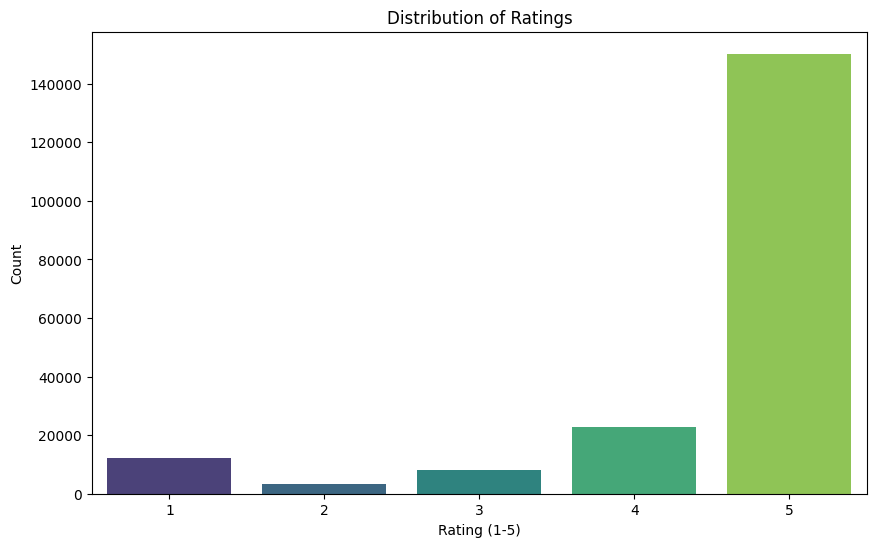

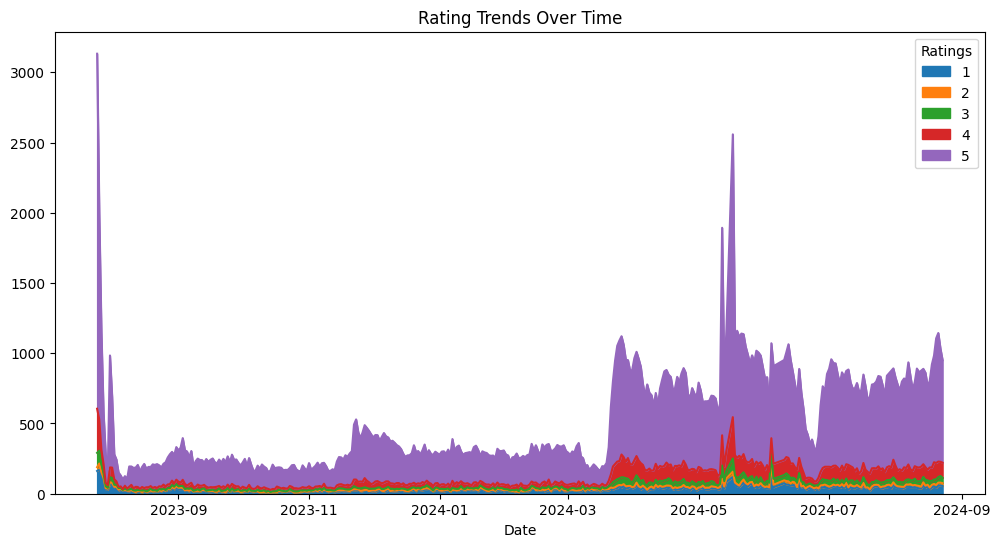

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='Ratings', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.show()

df['Date'] = pd.to_datetime(df['Review Date']).dt.date
rating_over_time = df.groupby(['Date', 'Ratings']).size().unstack()
rating_over_time.plot(kind='area', stacked=True, figsize=(12,6))
plt.title('Rating Trends Over Time')
plt.show()

/tmp/ipython-input-1979500313.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Class', data=df, palette='Set2')


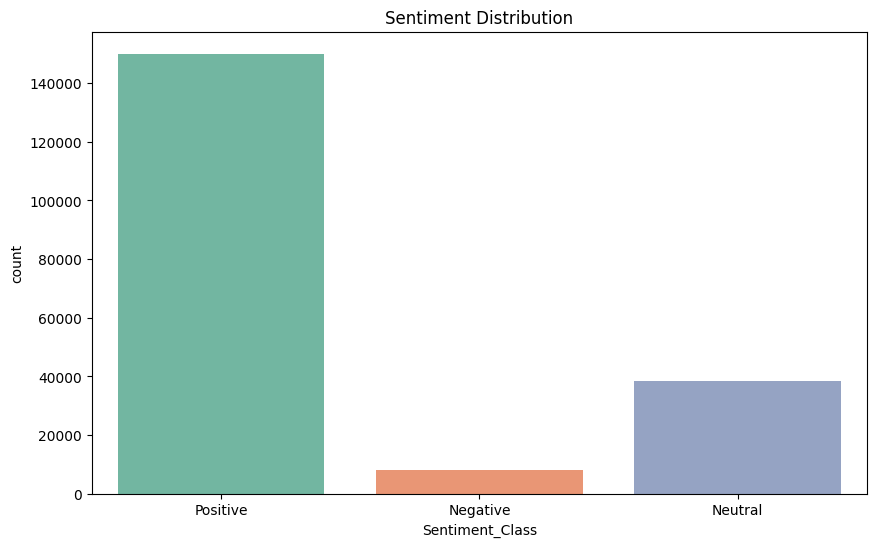

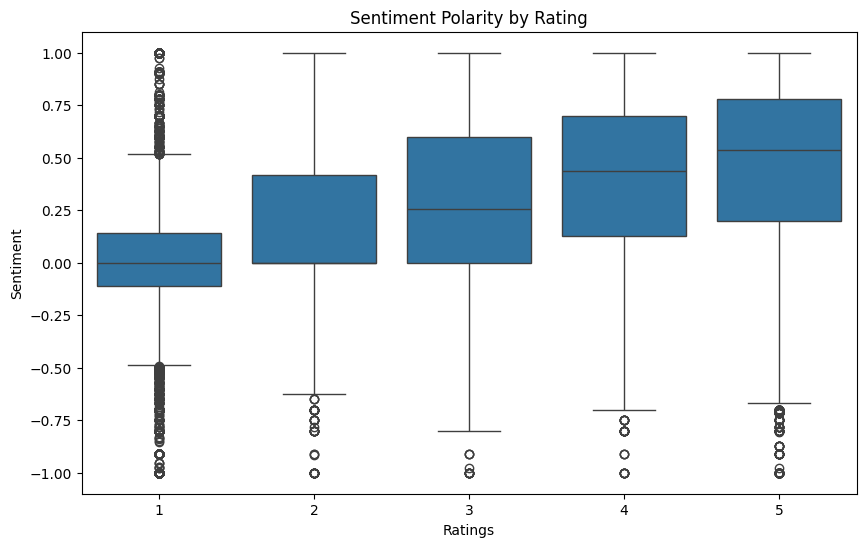

In [6]:
def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

df['Sentiment'] = df['Review'].apply(get_sentiment)
df['Sentiment_Class'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment_Class', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Ratings', y='Sentiment', data=df)
plt.title('Sentiment Polarity by Rating')
plt.show()

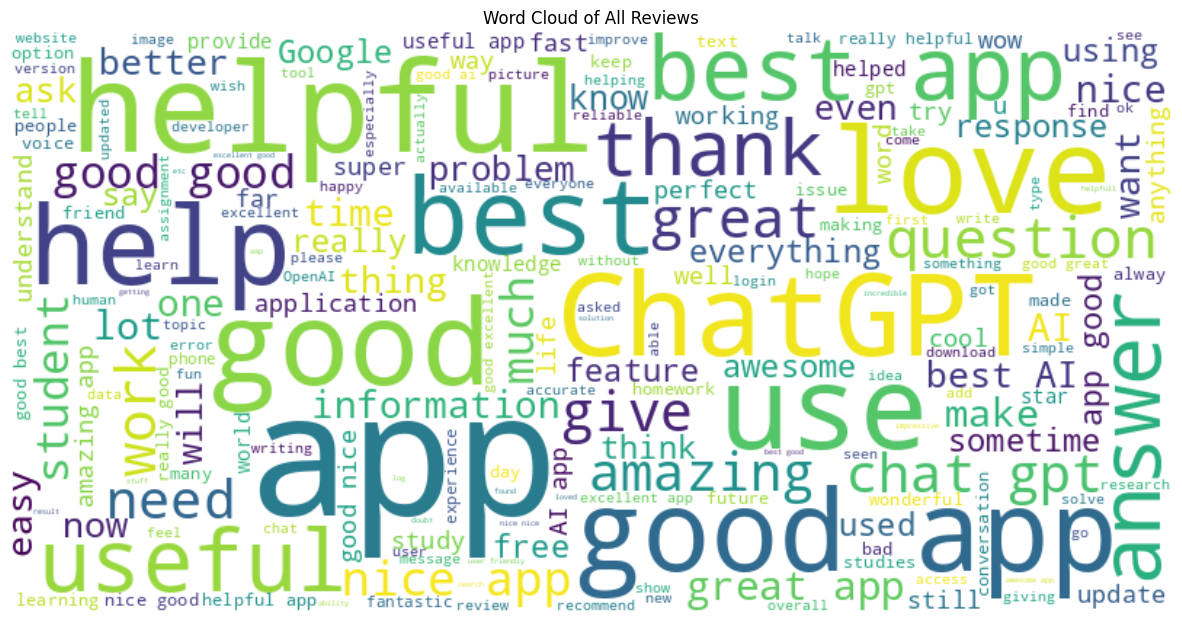

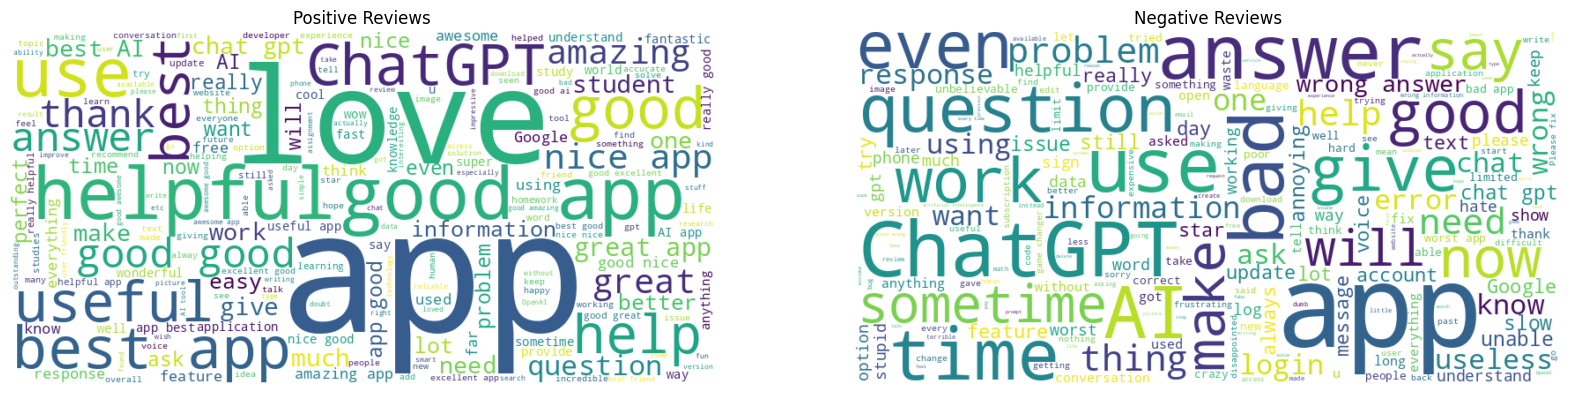

In [7]:
# All reviews
all_reviews = ' '.join(review for review in df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.show()

# Positive vs Negative word clouds
positive_reviews = ' '.join(review for review in df[df['Sentiment'] > 0]['Review'])
negative_reviews = ' '.join(review for review in df[df['Sentiment'] < 0]['Review'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

ax1.imshow(wordcloud_pos, interpolation='bilinear')
ax1.set_title('Positive Reviews')
ax1.axis('off')

ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Negative Reviews')
ax2.axis('off')

plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def preprocess(text):
    text = str(text).lower()
    text = ''.join([c for c in text if c.isalpha() or c == ' '])
    return text

df['Cleaned_Review'] = df['Review'].apply(preprocess)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['Cleaned_Review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 1:
best app ai chat gpt like voice better friend fantastic
Topic 2:
good app nice helpful really helps lot help thank cool
Topic 3:
amazing love awesome app just dont use time work doesnt
Topic 4:
useful excellent app use students hai aap ok easy study
Topic 5:
great app chatgpt answer answers information ai questions super like


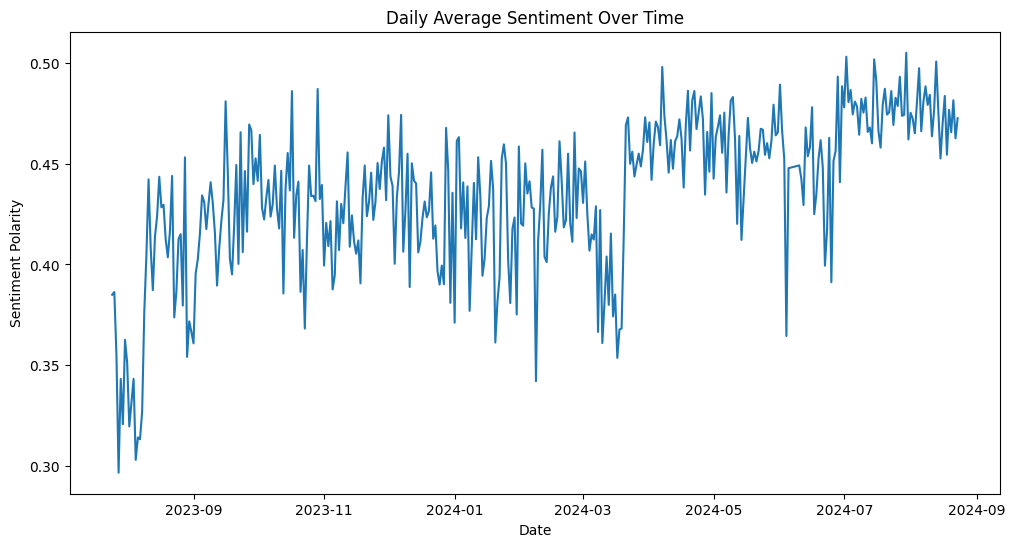

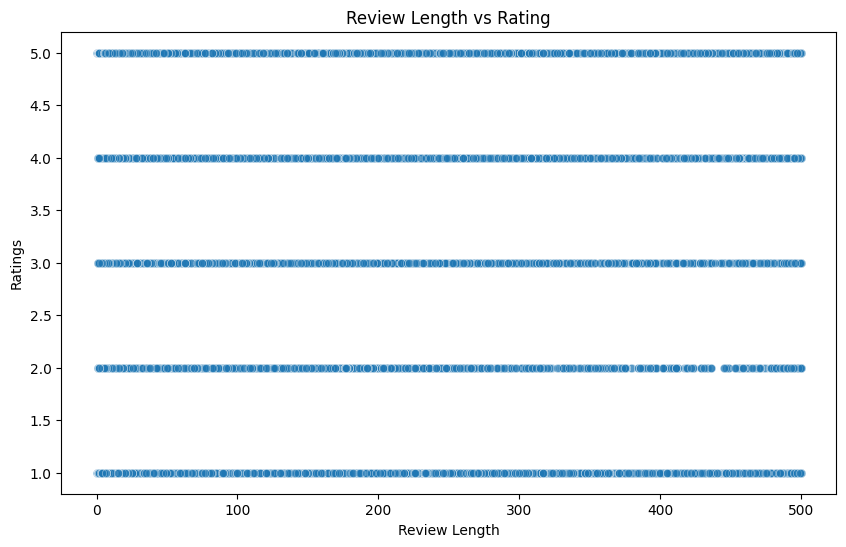

In [9]:
# Time series analysis of sentiment
df['Date'] = pd.to_datetime(df['Review Date']).dt.date
daily_sentiment = df.groupby('Date')['Sentiment'].mean()

plt.figure(figsize=(12,6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Over Time')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Date')
plt.show()

# Review length vs rating
plt.figure(figsize=(10,6))
sns.scatterplot(x='Review Length', y='Ratings', data=df, alpha=0.5)
plt.title('Review Length vs Rating')
plt.show()

In [10]:
# Performance Evaluation for Sentiment Model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Check if ground truth exists
if 'True_Sentiment' in df.columns:
    # Ensure both columns are strings
    y_true = df['True_Sentiment'].astype(str)
    y_pred = df['Sentiment_Class'].astype(str)

    # 2. Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Sentiment Classification Accuracy: {accuracy:.3f}")

    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=['Positive', 'Negative', 'Neutral'])
    print("Confusion Matrix:\n", cm)

    # 4. Classification Report
    report = classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral'])
    print("Classification Report:\n", report)

    # 5. Confusion Matrix Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative', 'Neutral'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("No ground truth column ('True_Sentiment') found for evaluation.")
    # Indirect metrics if no ground truth
    # Example: correlation between sentiment polarity and ratings
    if 'Ratings' in df.columns:
        corr = df['Sentiment'].corr(df['Ratings'])
        print(f"Correlation between sentiment polarity and ratings: {corr:.3f}")
    # Distribution comparison
    print(df['Sentiment_Class'].value_counts(normalize=True) * 100)


No ground truth column ('True_Sentiment') found for evaluation.
Correlation between sentiment polarity and ratings: 0.332
Sentiment_Class
Positive    76.308285
Neutral     19.546885
Negative     4.144830
Name: proportion, dtype: float64


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Evaluation metrics (MAE, RMSE, R²) cannot be calculated as there is no 'True_Rating' column in the dataset to compare against the predicted 'Ratings'.")
print("\nDistribution of Predicted Ratings:")
print(df['Ratings'].value_counts(normalize=True) * 100)

Evaluation metrics (MAE, RMSE, R²) cannot be calculated as there is no 'True_Rating' column in the dataset to compare against the predicted 'Ratings'.

Distribution of Predicted Ratings:
Ratings
5    76.357084
4    11.638972
1     6.142014
3     4.146355
2     1.715575
Name: proportion, dtype: float64


/tmp/ipython-input-327025597.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Ratings', data=df, palette='viridis')


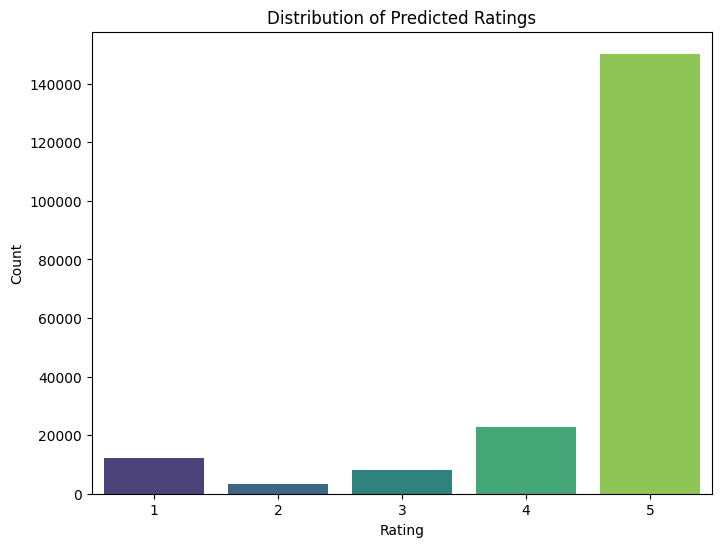

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Ratings', data=df, palette='viridis')
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()